# Import librairies & Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [3]:
df_cust = pd.read_csv('Mall_Customers.csv',sep=",")
df_cust

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


# Exploratory Data Analysis

In [4]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df_cust.drop(columns=["CustomerID"], inplace=True )
df_cust.columns
df_cust["Gender"] = df_cust["Gender"].map({
    "Female":0,
    "Male":1
})

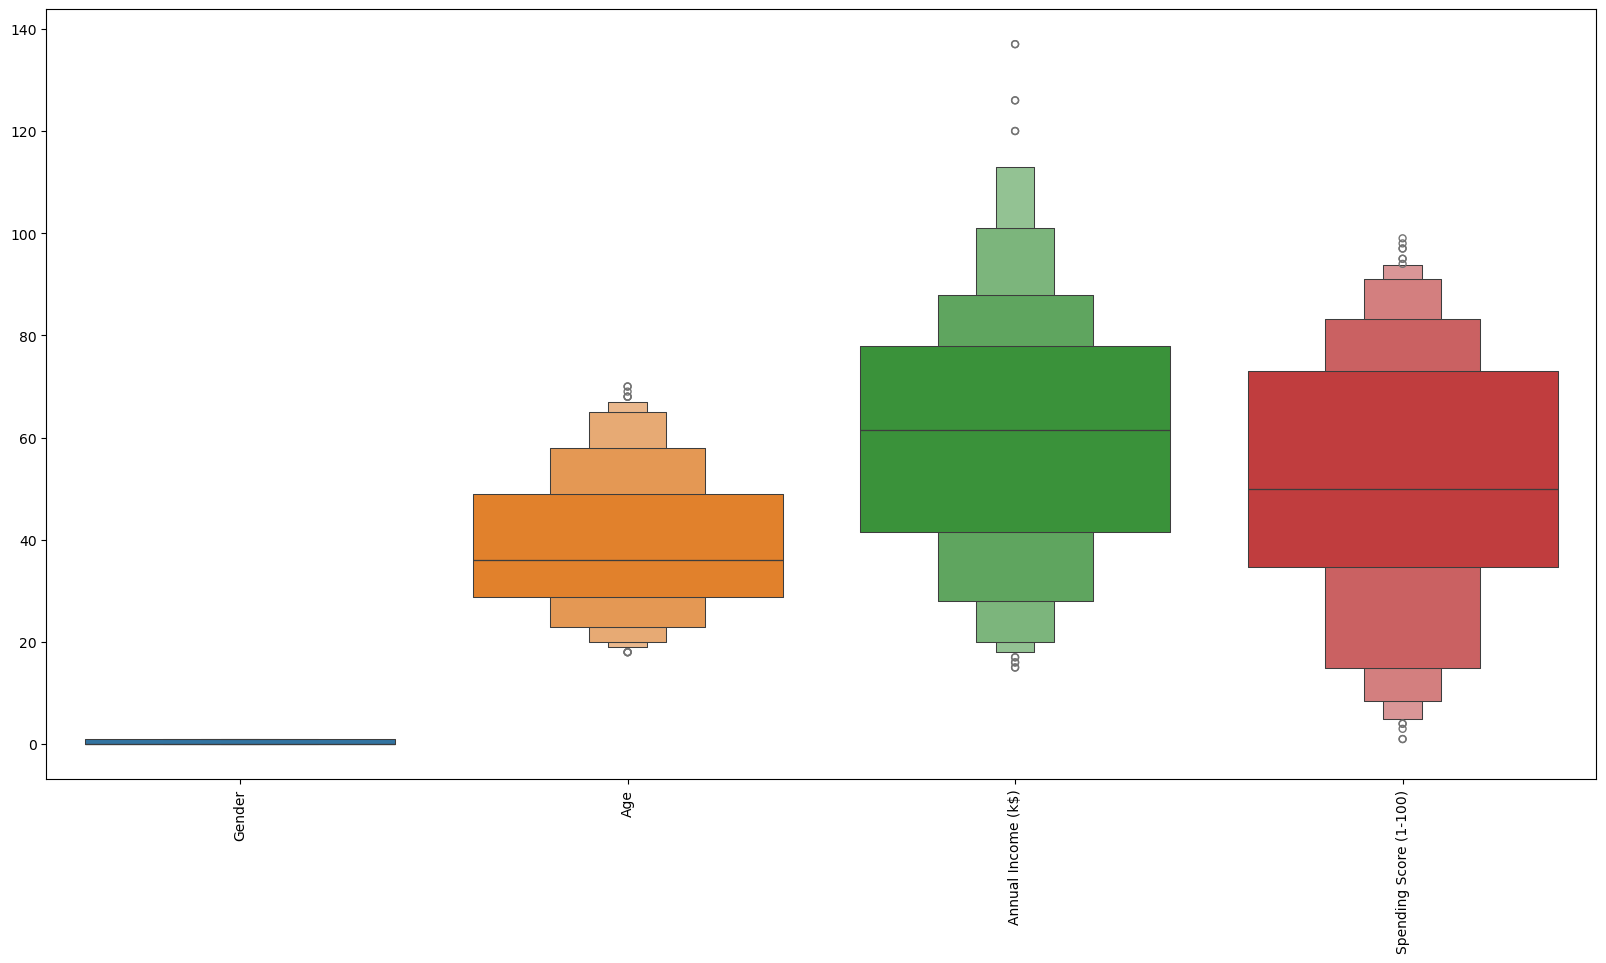

In [7]:
# Prepairing attributes of scale data

plt.figure(figsize=(20,10))
sns.boxenplot(data = df_cust)
plt.xticks(rotation=90)
plt.show()

In [9]:
def remove_outliers(data: pd.DataFrame, column: str):
    q3, q1 = np.nanpercentile(data[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data
df_cust = remove_outliers(df_cust, 'Annual Income (k$)')
df_cust = remove_outliers(df_cust, 'Spending Score (1-100)')

In [11]:
df_cust.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

### Spending by marital status

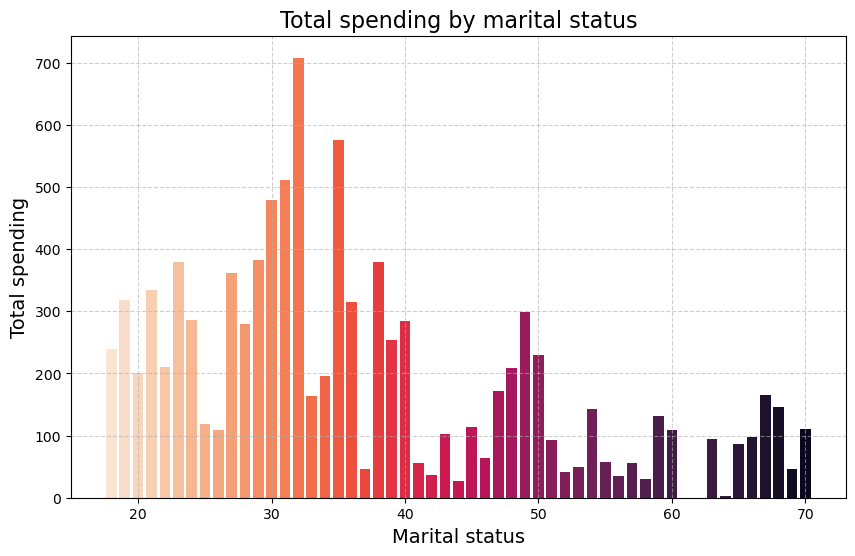

In [14]:
spending_by_marital_status = df_cust.groupby('Age')['Spending Score (1-100)'].sum()
norm = spending_by_marital_status / spending_by_marital_status.max()

plt.figure(figsize=(10, 6))
bars = plt.bar(spending_by_marital_status.index, spending_by_marital_status, 
               color=sns.color_palette("rocket_r", len(spending_by_marital_status)))


plt.title('Total spending by marital status', fontsize=16)
plt.xlabel('Marital status', fontsize=14)
plt.ylabel('Total spending', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Preprocessing data (encoding, feature engineering...)

## Encode columns Education and Marital_Status

In [15]:
df_cust.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


### Correlations

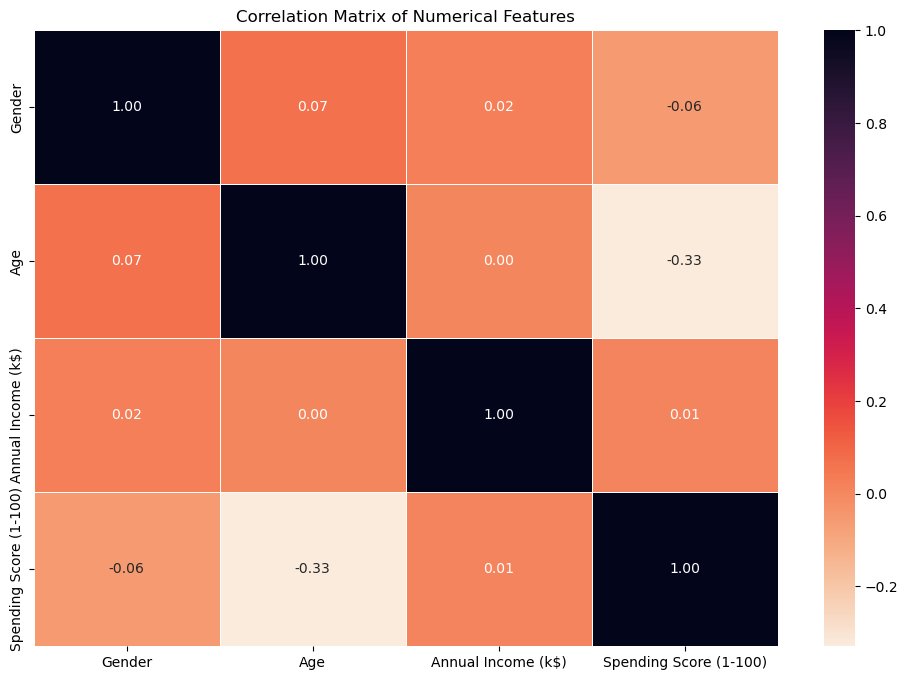

In [16]:
numerical_cols = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

corr_matrix = df_cust[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='rocket_r', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Exemple of insights : 

NumDealsPurchases and Income (-0.08): This slightly negative correlation shows that higher-income customers tend to be less interested in purchasing via discounts, possibly indicating price insensitivity

## Feature engineering

Fex examples of useful features created

<Figure size 800x600 with 0 Axes>

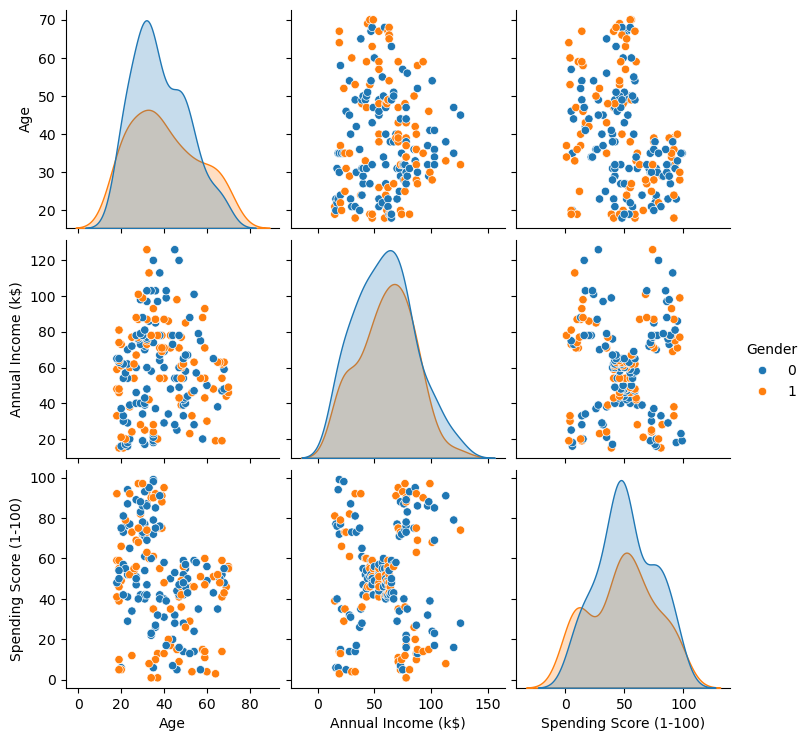

In [17]:
plt.figure(figsize=(8, 6))
sns.pairplot(df_cust, hue="Gender",
             plot_kws={'color': '#781C68'},
             diag_kws={'color': '#781C68', 'fill': True}) 
plt.show()

# Clustering

In [18]:
df_cust.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

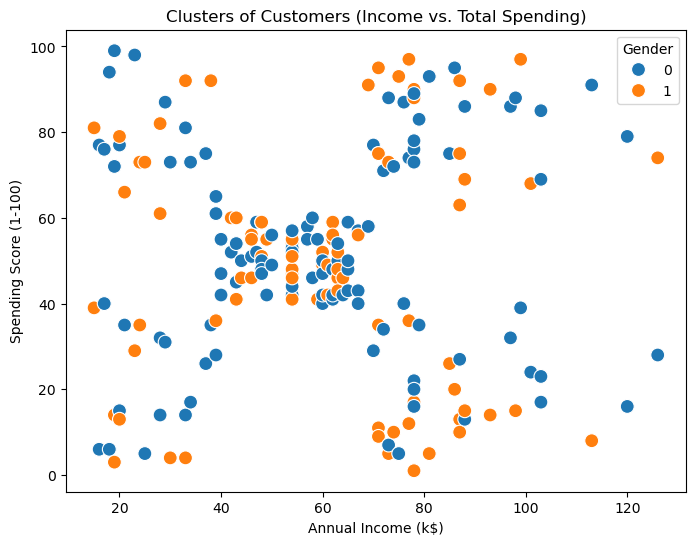

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df_cust, s=100, color='#781C68', hue="Gender") 
plt.title('Clusters of Customers (Income vs. Total Spending)')
plt.show()

In [20]:



# Scaling the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cust)

# Convert the scaled data back to a DataFrame (optional, for easy manipulation)
scaled_df = pd.DataFrame(scaled_features, columns=df_cust.columns)

## Elbow Method for Determining Optimal Clusters
The Elbow Method is a technique used to determine the optimal number of clusters (K) for K-Means clustering. The goal is to choose a K value that minimizes the sum of squared distances between each point and its assigned cluster center, known as the Sum of Squared Errors (SSE).

In [23]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN # WE HAVE HERE THREE TYPE OF MODEL TO USE

def compare_algorithms(X, max_clusters):
  results = []
  cluster_range = range(2, max_clusters +1)

  #kmeans
  for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    clusters = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters) # the bigger it is, the better will be
    results.append(('KMeans',n_clusters,silhouette_avg))
  

  #agglomerativo
  for n_clusters in cluster_range:
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = agglomerative.fit_predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    results.append(('Agglomerative',n_clusters,silhouette_avg))

  #dbscan
  eps_values = np.arange(0.1,0.9,0.1)
  # eps come from 01 to 0.9
  for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(X)
    if len(set(clusters)) > 1:
      silhouette_avg = silhouette_score(X, clusters)
      results.append(('DBSCAN',eps,silhouette_avg))

  return results

results = compare_algorithms(scaled_df, 10)
df = pd.DataFrame(results, columns=['Agrupador','Clusters','Score'])
df.sort_values(by="Score", ascending=False).reset_index(drop=True)

,Agrupador,Clusters,Score
0,KMeans,10.0,0.406222
1,KMeans,9.0,0.406072
2,Agglomerative,10.0,0.405846
3,Agglomerative,9.0,0.389775
4,KMeans,8.0,0.374494
5,Agglomerative,8.0,0.372632
6,Agglomerative,7.0,0.339999
7,KMeans,5.0,0.316609
8,KMeans,7.0,0.312277
9,KMeans,6.0,0.310121


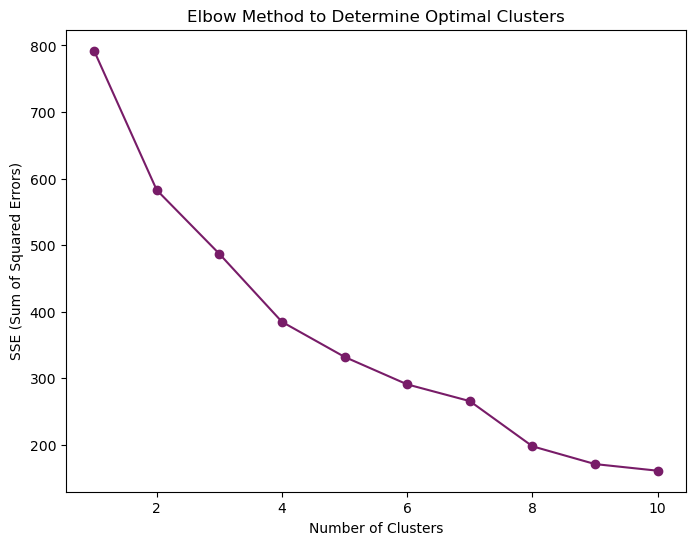

In [22]:
# Elbow Method to find the optimal number of clusters
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

# plot the Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', color='#781C68')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

Elbow Method suggests 3 or 4 clusters

## K-means

In [53]:
optimal_clusters = 4

# Running K-Means with the chosen number of (optimal) clusters
kmeans = KMeans(n_clusters=optimal_clusters,n_init=20, random_state=42)
df_cust['Cluster'] = kmeans.fit_predict(scaled_df)
df_cust.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Cluster', 'Cluster_PCA', 'Cluster_DBSCAN'],
      dtype='object')

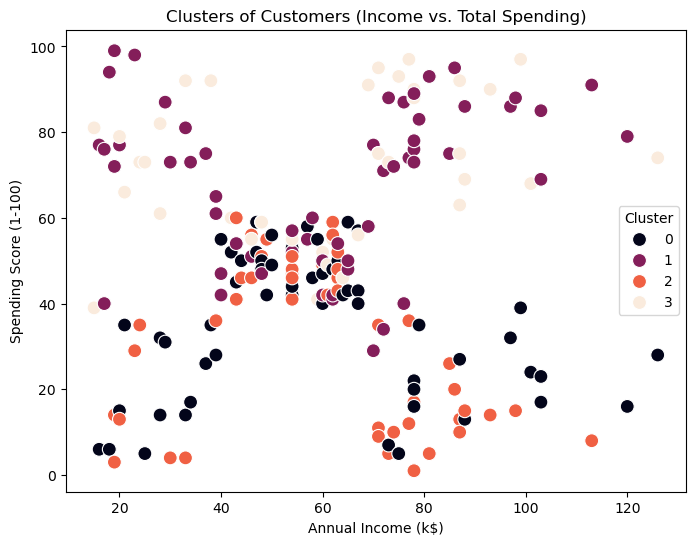

In [54]:
# Scatter plot to visualize the clusters based on Income and Total Spend
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df_cust, palette='rocket', s=100)
plt.title('Clusters of Customers (Income vs. Total Spending)')
plt.show()


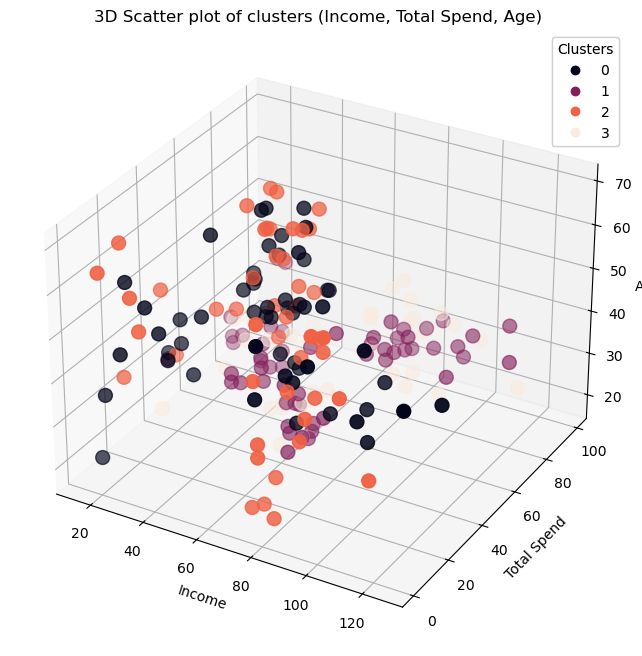

In [55]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_cust['Annual Income (k$)'], df_cust['Spending Score (1-100)'], df_cust['Age'], 
                     c=df_cust['Cluster'], cmap='rocket', s=100)

ax.set_xlabel('Income')
ax.set_ylabel('Total Spend')
ax.set_zlabel('Age')
plt.title('3D Scatter plot of clusters (Income, Total Spend, Age)')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()


## t-SNE 
"t-distributed Stochastic Neighbor Embedding" is a powerful machine learning algorithm primarily used for visualizing high-dimensional data by reducing its dimensions to 2 or 3, while preserving the structure and relationships between data points.

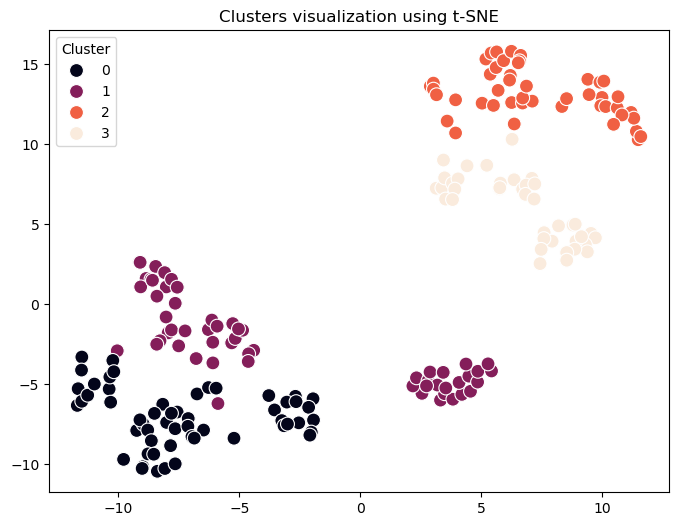

In [56]:
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_features[:,0], y=tsne_features[:,1], hue=df_cust['Cluster'], palette='rocket', s=100)
plt.title('Clusters visualization using t-SNE')
plt.show()

## Silhouette & others metrics

In [57]:
silhouette_avg = silhouette_score(scaled_df, df_cust['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.3005606551411489


In [58]:
db_score = davies_bouldin_score(scaled_df, df_cust['Cluster'])
print(f'Davies-Bouldin Index: {db_score}')

Davies-Bouldin Index: 1.3006535201430638


In [59]:
ch_score = calinski_harabasz_score(scaled_df, df_cust['Cluster'])
print(f'Calinski-Harabasz Score: {ch_score}')

Calinski-Harabasz Score: 69.00171168817184


## Improve K-means with PCA

In [60]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_df)

kmeans_pca = KMeans(n_clusters=optimal_clusters,n_init=20, random_state=42)
df_cust['Cluster_PCA'] = kmeans_pca.fit_predict(pca_features)

In [61]:
silhouette_avg_pca = silhouette_score(pca_features, df_cust['Cluster_PCA'])
db_score_pca = davies_bouldin_score(pca_features, df_cust['Cluster_PCA'])
ch_score_pca = calinski_harabasz_score(pca_features, df_cust['Cluster_PCA'])

print(f'Silhouette Score (PCA): {silhouette_avg_pca}')
print(f'Davies-Bouldin Index (PCA): {db_score_pca}')
print(f'Calinski-Harabasz Score (PCA): {ch_score_pca}')

Silhouette Score (PCA): 0.3971871816719354
Davies-Bouldin Index (PCA): 0.8565429230364804
Calinski-Harabasz Score (PCA): 178.3531476141532


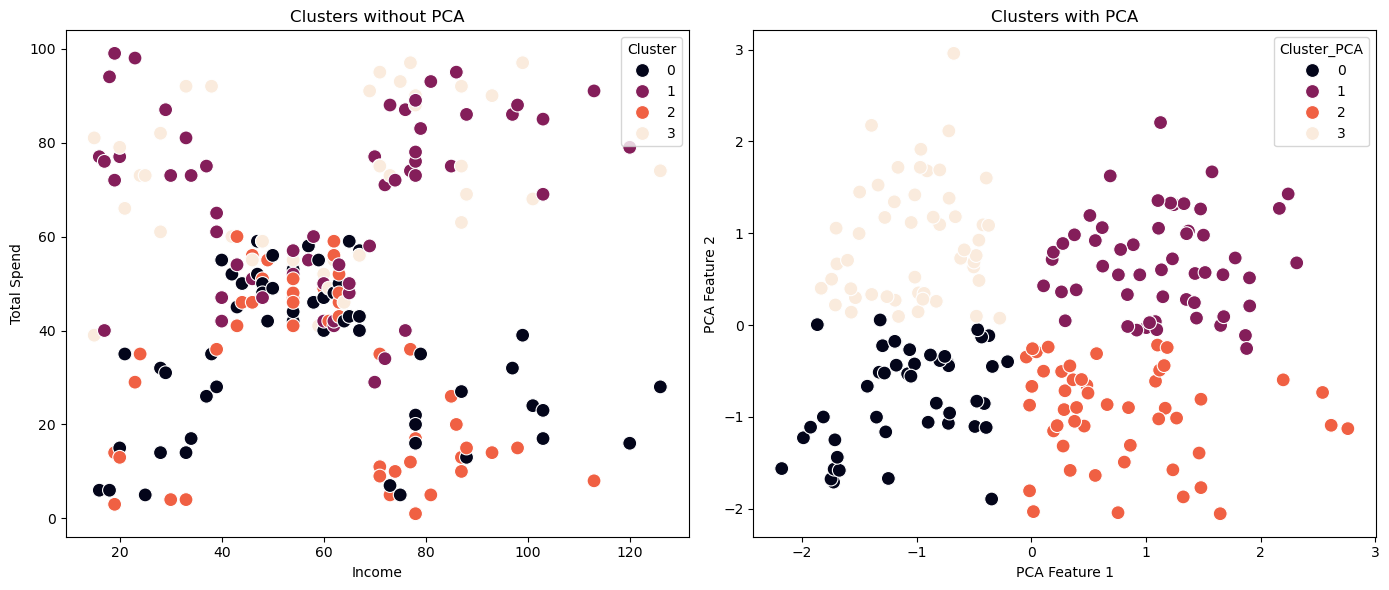

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot without PCA
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df_cust, palette='rocket', s=100, ax=ax[0])
ax[0].set_title('Clusters without PCA')
ax[0].set_xlabel('Income')
ax[0].set_ylabel('Total Spend')

# Plot with PCA
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=df_cust['Cluster_PCA'], palette='rocket', s=100, ax=ax[1])
ax[1].set_title('Clusters with PCA')
ax[1].set_xlabel('PCA Feature 1')
ax[1].set_ylabel('PCA Feature 2')

plt.tight_layout()
plt.show()

In [64]:
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each principal component: {explained_variance}')
print(f'Total variance explained by PCA: {sum(explained_variance)}')


Explained variance by each principal component: [0.33807564 0.25402715]
Total variance explained by PCA: 0.5921027882445438


The first two principal components capture approximately 77% of the total variance in the original data. This means that although some information is lost (about 23%), PCA still retains most of the important variance in the data. This explains why the clustering improved with PCA, as it condensed the data into a lower-dimensional space that is still representative of the original feature set.

### Comparison of Clustering with and without PCA:

#### Silhouette Score:

Without PCA: 0.3047

With PCA: 0.3937

Interpretation: The silhouette score is better after applying PCA, which suggests that the clusters are better separated in the PCA-transformed space. A silhouette score closer to 1 indicates better-defined clusters. The improvement indicates that PCA has likely simplified the relationships between features, making the clusters more distinct.

#### Davies-Bouldin Index:

Without PCA: 1.1934

With PCA: 0.8859

Interpretation: A lower Davies-Bouldin Index after PCA indicates that the clusters are more compact and well-separated. This metric shows that the clusters have improved in quality after dimensionality reduction.

#### Calinski-Harabasz Score:

Without PCA: 1075.85

With PCA: 1925.21

Interpretation: The Calinski-Harabasz score has significantly increased after applying PCA, which indicates better cluster separation and compactness. A higher value is better because it suggests that the data points within a cluster are closer to each other, and the clusters themselves are well-separated.

# Others models of clustering

## DBSCAN

eps: Maximum distance between two samples to be considered in the same neighborhood

min_samples: Minimum number of points in a neighborhood to form a dense region (a cluster)

In [70]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_cust['Cluster_DBSCAN'] = dbscan.fit_predict(scaled_df)

# Evaluate clustering
if len(set(df_cust['Cluster_DBSCAN'])) > 1:  # Check if more than one cluster was found
    silhouette_avg_dbscan = silhouette_score(scaled_df, df_cust['Cluster_DBSCAN'])
    db_score_dbscan = davies_bouldin_score(scaled_df, df_cust['Cluster_DBSCAN'])
    ch_score_dbscan = calinski_harabasz_score(scaled_df, df_cust['Cluster_DBSCAN'])

    print(f'Silhouette Score (DBSCAN): {silhouette_avg_dbscan}')
    print(f'Davies-Bouldin Index (DBSCAN): {db_score_dbscan}')
    print(f'Calinski-Harabasz Score (DBSCAN): {ch_score_dbscan}')
else:
    print("DBSCAN did not find enough clusters.")

Silhouette Score (DBSCAN): 0.0007296552640720069
Davies-Bouldin Index (DBSCAN): 1.4243627869053164
Calinski-Harabasz Score (DBSCAN): 10.809181756828442


In [66]:
df_cust.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Cluster', 'Cluster_PCA', 'Cluster_DBSCAN'],
      dtype='object')

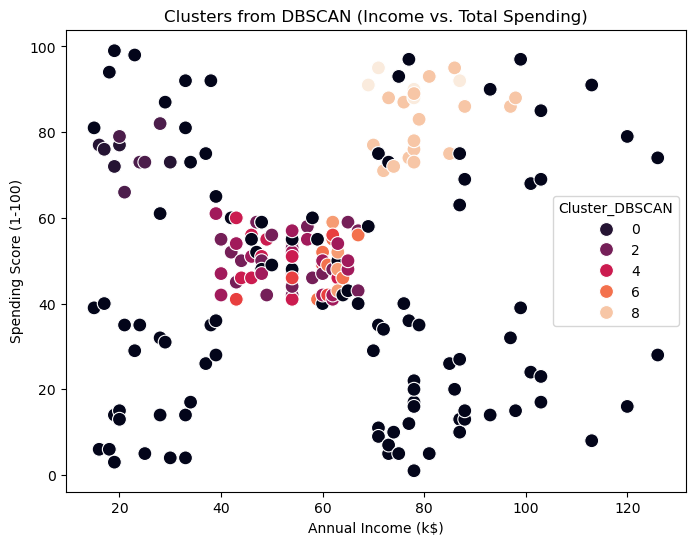

In [71]:
plt.figure(figsize=(8,6))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster_DBSCAN', data=df_cust, palette='rocket', s=100)
plt.title('Clusters from DBSCAN (Income vs. Total Spending)')
plt.show()

## Agglomerative Clustering (Hierarchical Clustering)

In [76]:
agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters)
df_cust['Cluster_Agglo'] = agglomerative.fit_predict(scaled_df)

silhouette_avg_agglo = silhouette_score(scaled_df, df_cust['Cluster_Agglo'])
db_score_agglo = davies_bouldin_score(scaled_df, df_cust['Cluster_Agglo'])
ch_score_agglo = calinski_harabasz_score(scaled_df, df_cust['Cluster_Agglo'])

print(f'Silhouette Score (Agglomerative): {silhouette_avg_agglo}')
print(f'Davies-Bouldin Index (Agglomerative): {db_score_agglo}')
print(f'Calinski-Harabasz Score (Agglomerative): {ch_score_agglo}')

Silhouette Score (Agglomerative): 0.2601728939012523
Davies-Bouldin Index (Agglomerative): 1.4171501468613403
Calinski-Harabasz Score (Agglomerative): 58.44615916498731


In [78]:
df_cust.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Cluster', 'Cluster_PCA', 'Cluster_DBSCAN', 'Cluster_Agglo'],
      dtype='object')

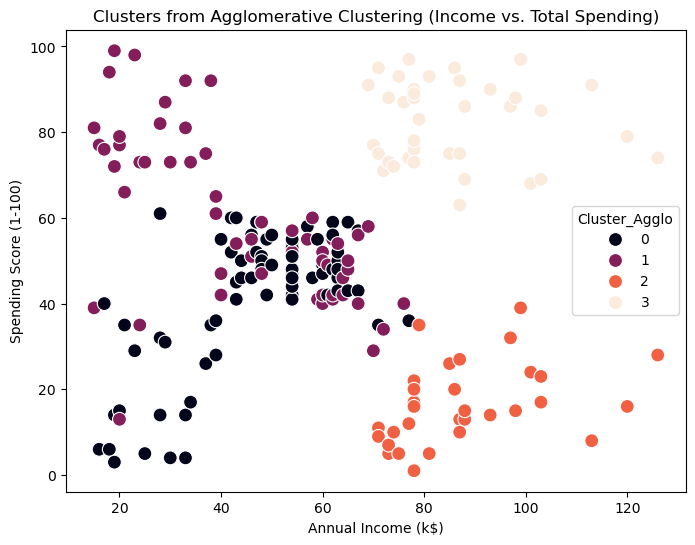

In [79]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster_Agglo', data=df_cust, palette='rocket', s=100)
plt.title('Clusters from Agglomerative Clustering (Income vs. Total Spending)')
plt.show()

## Gaussian Mixture Model

In [80]:
gmm = GaussianMixture(n_components=4, random_state=42)
df_cust['Cluster_GMM'] = gmm.fit_predict(scaled_df)

silhouette_avg_gmm = silhouette_score(scaled_df, df_cust['Cluster_GMM'])
db_score_gmm = davies_bouldin_score(scaled_df, df_cust['Cluster_GMM'])
ch_score_gmm = calinski_harabasz_score(scaled_df, df_cust['Cluster_GMM'])

print(f'Silhouette Score (GMM): {silhouette_avg_gmm}')
print(f'Davies-Bouldin Index (GMM): {db_score_gmm}')
print(f'Calinski-Harabasz Score (GMM): {ch_score_gmm}')

Silhouette Score (GMM): 0.18795018985915377
Davies-Bouldin Index (GMM): 1.303662259760276
Calinski-Harabasz Score (GMM): 35.722530355991026


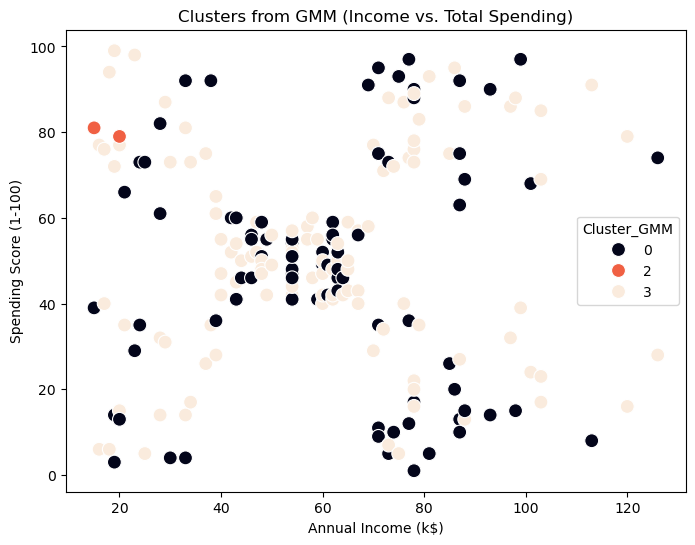

In [81]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster_GMM', data=df_cust, palette='rocket', s=100)
plt.title('Clusters from GMM (Income vs. Total Spending)')
plt.show()

# Customer segments from the clusters

## Visualizations Cluster with boxplot

In [83]:
df_cust.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Cluster', 'Cluster_PCA', 'Cluster_DBSCAN', 'Cluster_Agglo',
       'Cluster_GMM'],
      dtype='object')

/tmp/ipykernel_80299/3080909091.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_PCA', y=column, data=df_cust, palette='rocket')


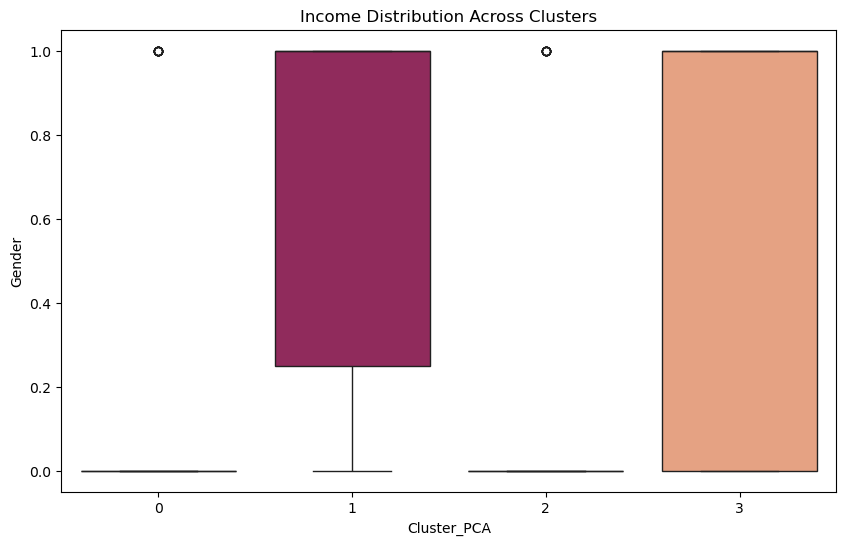

/tmp/ipykernel_80299/3080909091.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_PCA', y=column, data=df_cust, palette='rocket')


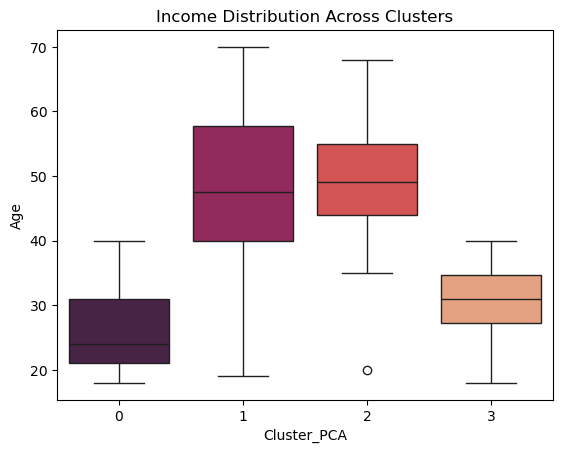

/tmp/ipykernel_80299/3080909091.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_PCA', y=column, data=df_cust, palette='rocket')


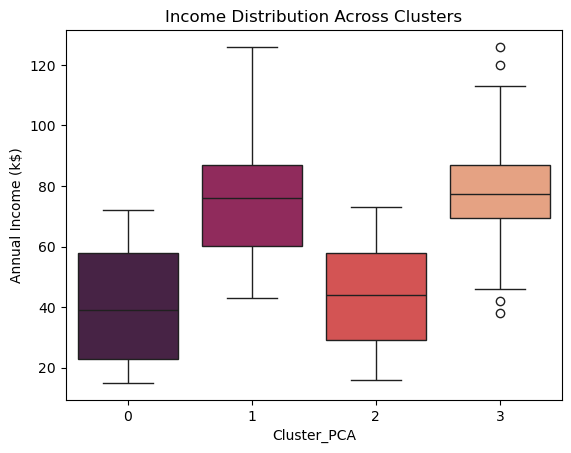

/tmp/ipykernel_80299/3080909091.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_PCA', y=column, data=df_cust, palette='rocket')


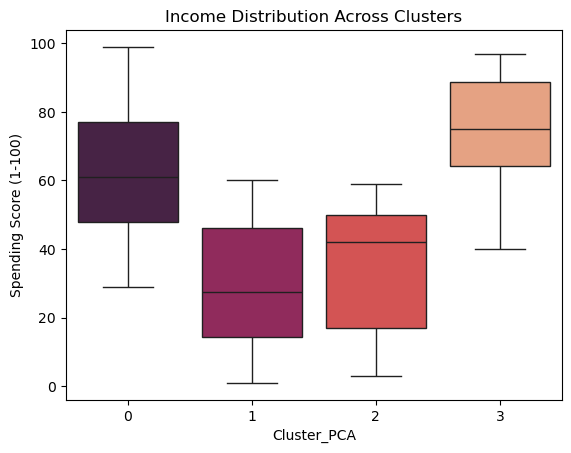

In [85]:
plt.figure(figsize=(10, 6))

for column in ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    
    sns.boxplot(x='Cluster_PCA', y=column, data=df_cust, palette='rocket')
    plt.title('Income Distribution Across Clusters')
    plt.show()
